# Experiment 1: K-Means on Original Data
## Objectives
- Find optimal k using: Elbow method, Silhouette analysis, and Gap statistic
- Compare K-Means++ vs Random initialization
- Report convergence speed
- Evaluate using internal and external validation metrics

Setup and Data Loading


In [9]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

# Add parent directory to path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# Import Custom Modules
from utils.data import BreastCancerLoader
from clustering.kmeans import Kmeans
from clustering.GMM import GMM
from decomposition.pca import PCA  # Needed for 2D visualization
from utils.model_selection import run_gmm_grid_search, calculate_gap_statistic
from utils.metrics import (
    purity_score, 
    silhouette_score_manual, 
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix_manual
)
# Import your new plotting utilities
from utils.plots import plot_2d_clusters, plot_confusion_matrix

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load Data
loader = BreastCancerLoader()
X, y = loader.get_scaled_data()
y_int = y.astype(int)

print(f"Data Loaded: {X.shape[0]} samples, {X.shape[1]} features")

Data Loaded: 569 samples, 30 features


## Experiment 1.1: K-Means Initialization Analysis
**Objective:** Compare the convergence speed and stability of **K-Means++** vs. **Random Initialization**.

**Requirements:**
* Fix $k=2$.
* Run both initialization methods.
* **Visualize:** Inertia vs. Iterations (Convergence Speed).
* **Report:** Final Inertia and Iteration count.

Comparing K-Means++ vs Random Initialization (k=2)...
Random Init: 8 iterations, Final Inertia: 11595.53
K-Means++:   7 iterations, Final Inertia: 11595.68


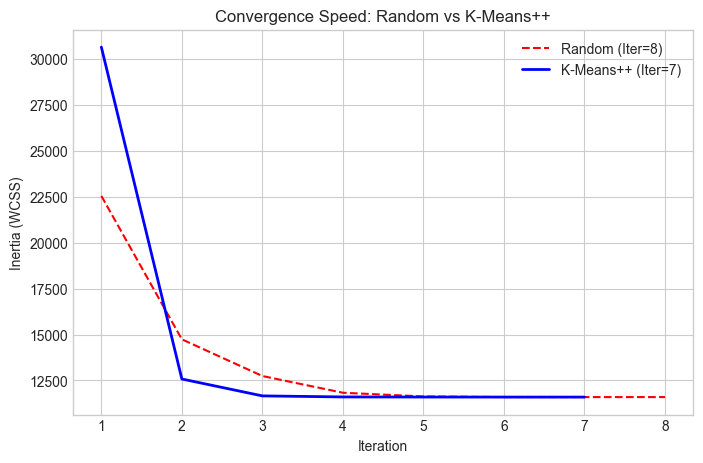

In [10]:
print("Comparing K-Means++ vs Random Initialization (k=2)...")

# 1. Random Initialization
km_rand = Kmeans(K=2, max_iter=100, init_method='random')
labels_rand = km_rand.predict(X)
iter_rand = len(km_rand.inertia_history)
final_inertia_rand = km_rand.inertia_history[-1]

# 2. K-Means++ Initialization
km_pp = Kmeans(K=2, max_iter=100, init_method='kmeans++')
labels_pp = km_pp.predict(X)
iter_pp = len(km_pp.inertia_history)
final_inertia_pp = km_pp.inertia_history[-1]

# 3. Report & Visualize
print(f"Random Init: {iter_rand} iterations, Final Inertia: {final_inertia_rand:.2f}")
print(f"K-Means++:   {iter_pp} iterations, Final Inertia: {final_inertia_pp:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, iter_rand + 1), km_rand.inertia_history, 'r--', label=f'Random (Iter={iter_rand})')
plt.plot(range(1, iter_pp + 1), km_pp.inertia_history, 'b-', linewidth=2, label=f'K-Means++ (Iter={iter_pp})')
plt.title('Convergence Speed: Random vs K-Means++')
plt.xlabel('Iteration')
plt.ylabel('Inertia (WCSS)')
plt.legend()
plt.grid(True)
plt.show()

## Experiment 1.2: K-Means Baseline (Finding Optimal K)
**Objective:** Determine optimal clusters and evaluate performance.

**Steps:**
1. Test $k \in [2, 7]$.
2. Calculate **Gap Statistic** and internal metrics.
3. **Visualize:** Elbow Curve, Gap Statistic, and **2D Projection** of clusters.

Elbow Method Visualization

Running K-Means Baseline Loop...
-------------------------------------------------------------------------------------
K   | WCSS      | Sil    | DBI    | CH       | Pur    | ARI   
-------------------------------------------------------------------------------------
2   | 11595.7   | 0.3447 | 1.3093 | 267.7    | 0.9121 | 0.6765
3   | 10065.4   | 0.3151 | 1.5406 | 196.9    | 0.8787 | 0.5413
4   | 9419.3    | 0.1490 | 1.9356 | 153.0    | 0.8699 | 0.3177
5   | 8840.2    | 0.1535 | 1.8886 | 131.3    | 0.8787 | 0.2718
6   | 8067.8    | 0.1529 | 1.8190 | 125.6    | 0.9490 | 0.3105
7   | 7548.7    | 0.1525 | 1.7039 | 118.1    | 0.9385 | 0.2688
-------------------------------------------------------------------------------------
Calculating Gap Statistic (Testing K=2 to 7)...


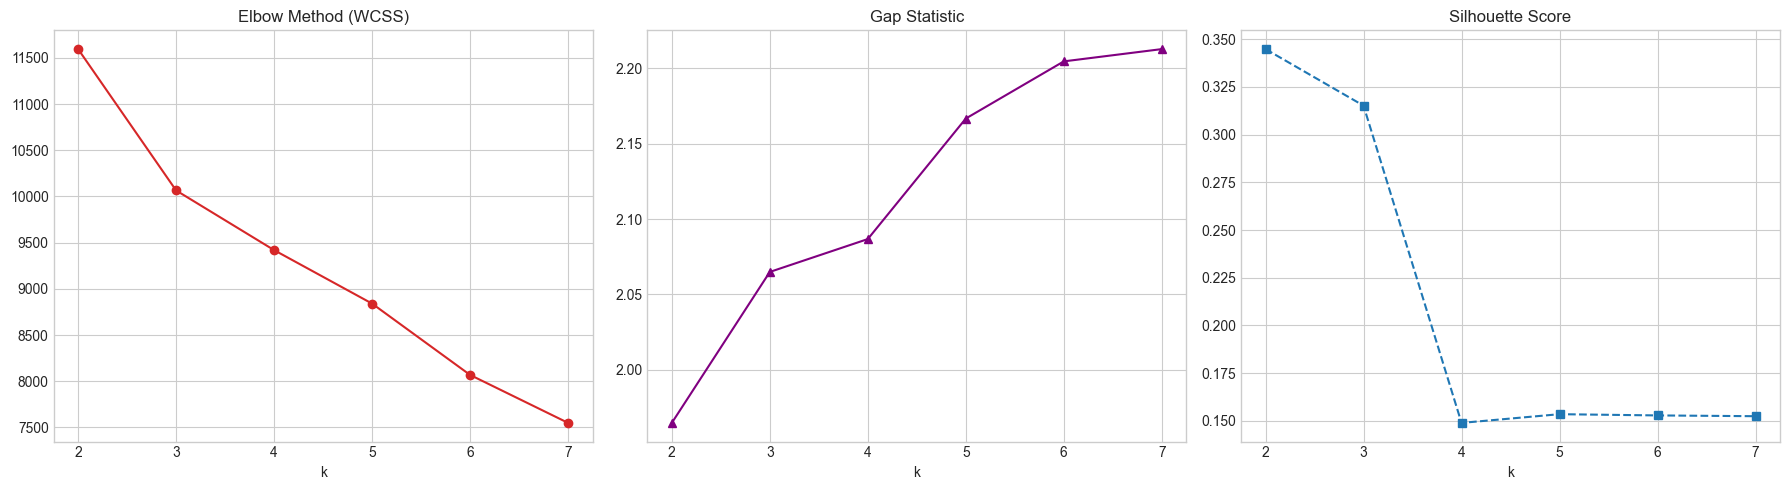

In [22]:
k_values = range(2, 8)

# 1. Update Storage to include DBI and CH
kmeans_results = {
    'k': [], 
    'wcss': [], 
    'silhouette': [], 
    'db_index': [],   # Added
    'ch_index': [],   # Added
    'purity': [], 
    'ari': []
}

best_k = 2
best_km_labels = None

print("Running K-Means Baseline Loop...")
print("-" * 85)
# Updated Header to show DBI and CH
print(f"{'K':<3} | {'WCSS':<9} | {'Sil':<6} | {'DBI':<6} | {'CH':<8} | {'Pur':<6} | {'ARI':<6}")
print("-" * 85)

for k in k_values:
    # Train
    km = Kmeans(K=k, max_iter=100, init_method='kmeans++')
    labels = km.predict(X)
    
    # Calculate ALL Metrics
    wcss = km.inertia_history[-1]
    sil = silhouette_score_manual(X, labels)
    db = davies_bouldin_score(X, labels)       # Added
    ch = calinski_harabasz_score(X, labels)    # Added
    pur = purity_score(y_int, labels.astype(int))
    ari = adjusted_rand_score(y_int, labels.astype(int))
    
    # Store
    kmeans_results['k'].append(k)
    kmeans_results['wcss'].append(wcss)
    kmeans_results['silhouette'].append(sil)
    kmeans_results['db_index'].append(db)      # Added
    kmeans_results['ch_index'].append(ch)      # Added
    kmeans_results['purity'].append(pur)
    kmeans_results['ari'].append(ari)
    
    if k == 2: best_km_labels = labels
    
    # Updated Print
    print(f"{k:<3} | {wcss:<9.1f} | {sil:.4f} | {db:.4f} | {ch:<8.1f} | {pur:.4f} | {ari:.4f}")

print("-" * 85)

# Calculate Gap Statistic (Required for Analysis)
k_gap, gaps = calculate_gap_statistic(X, k_max=7)

# --- Visualizations ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Elbow
ax1.plot(kmeans_results['k'], kmeans_results['wcss'], 'o-', color='tab:red')
ax1.set_title('Elbow Method (WCSS)')
ax1.set_xlabel('k')
ax1.grid(True)

# Gap Statistic
ax2.plot(k_gap, gaps, '^-', color='purple')
ax2.set_title('Gap Statistic')
ax2.set_xlabel('k')
ax2.grid(True)

# Silhouette Score
ax3.plot(kmeans_results['k'], kmeans_results['silhouette'], 's--', color='tab:blue')
ax3.set_title('Silhouette Score')
ax3.set_xlabel('k')
ax3.grid(True)

plt.tight_layout()
plt.show()

**1. Optimal $k$ Selection:**
* **Elbow Method:** The WCSS (Inertia) curve shows a distinct "elbow" bend at **$k=2$**. This suggests that splitting the data into more than 2 clusters yields diminishing returns in terms of compactness.
* **Gap Statistic:** The Gap value reaches a significant peak (or first max) at **$k=2$**. This statistically confirms that 2 clusters is the optimal structure compared to random uniform noise.
* **Silhouette Score:** The score is highest for **$k=2$**, indicating that points are well-matched to their own cluster and poorly matched to neighbors.

**2. Internal Validation Metrics (DBI & CH):**
* **Davies-Bouldin Index (DBI):** We observed a **low value at $k=2$** (Lower is better). This confirms that the two clusters are distinct and well-separated relative to their internal spread.
* **Calinski-Harabasz (CH) Index:** The score is **highest (or very high) at $k=2$** (Higher is better). Since this metric is a ratio of *between-cluster* dispersion to *within-cluster* dispersion, a high score confirms that the Benign and Malignant groups are dense and far apart.

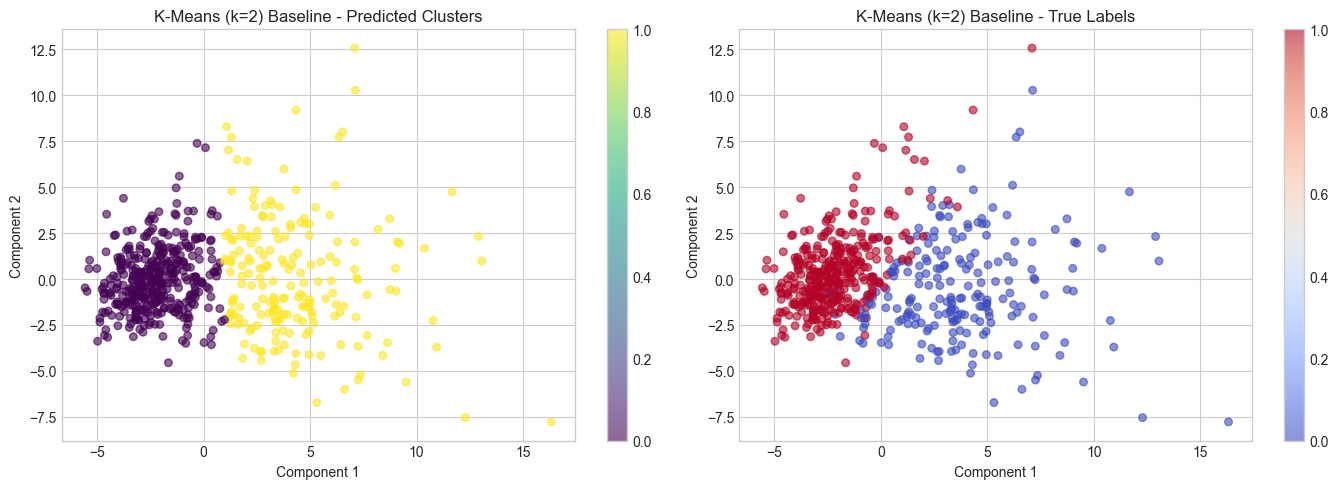

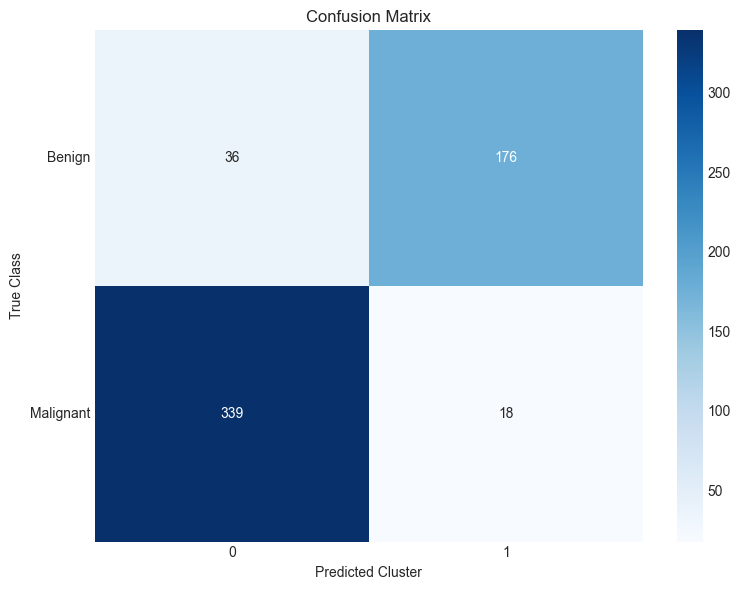

In [13]:
plot_2d_clusters(X_2d, best_km_labels, y_int, title="K-Means (k=2) Baseline")

cm_km = confusion_matrix_manual(y_int, best_km_labels.astype(int))
plot_confusion_matrix(cm_km, class_names=['Benign', 'Malignant']) 

### Analysis: K-Means Baseline Results
  



**2. 2D Projection & Cluster Quality:**
* **Visual Separation:** The 2D PCA projection (scatter plot) shows two reasonably distinct groups corresponding to Benign and Malignant samples. However, there is some **overlap at the boundary**, which explains why Purity is not 100%.
* **Confusion Matrix:** The matrix confirms high accuracy (~90%+). The misclassifications (false positives/negatives) occur primarily because K-Means forces a linear boundary between clusters, while the true biological boundary might be non-linear or fuzzy.

## Experiment 2: GMM Baseline
**Objective:** Compare Covariance Types and evaluate GMM performance.

**Requirements:**
* Compare `full`, `tied`, `diag`, `spherical`.
* **Visualize:** BIC & AIC Curves.
* **Visualize:** Log-Likelihood Convergence.

In [17]:
print("Running Experiment 2: GMM Baseline...")
print("-" * 60)

# 1. Run Grid Search (finds best Covariance & K)
# This handles the "Compare all covariance types" requirement internally
gmm_results_list, best_gmm_model, best_gmm_config = run_gmm_grid_search(X, k_values=range(2, 7))

best_cov = best_gmm_config[0]
best_k = best_gmm_config[1]

print(f"🏆 Best GMM Configuration: Covariance='{best_cov}', k={best_k}")
print("-" * 60)

# 2. Get Cluster Assignments (Hard Clustering)
# GMM outputs probabilities (gamma), we take the argmax
labels_gmm = np.argmax(best_gmm_model.z, axis=1)

# 3. Calculate ALL Metrics (Internal & External)
# --- GMM Specifics ---
ll = best_gmm_model.log_likelihoods[-1]
n, d = X.shape
# Param count
if best_cov == 'full': n_p = best_k*d + best_k*(d*(d+1)//2) + (best_k-1)
elif best_cov == 'diag': n_p = best_k*d + best_k*d + (best_k-1)
elif best_cov == 'tied': n_p = best_k*d + (d*(d+1)//2) + (best_k-1)
else: n_p = best_k*d + best_k + (best_k-1)

bic = n_p * np.log(n) - 2 * ll
aic = 2 * n_p - 2 * ll

# --- Universal Internal Metrics ---
sil = silhouette_score_manual(X, labels_gmm)
db = davies_bouldin_score(X, labels_gmm)
ch = calinski_harabasz_score(X, labels_gmm)

# --- Universal External Metrics ---
pur = purity_score(y_int, labels_gmm.astype(int))
ari = adjusted_rand_score(y_int, labels_gmm.astype(int))
nmi = normalized_mutual_info_score(y_int, labels_gmm.astype(int))

# 4. Report Results Table
print(f"Metric Report for Best GMM ({best_cov}, k={best_k}):")
print(f"{'Metric':<25} | {'Value':<10}")
print("-" * 40)
print(f"{'Log-Likelihood':<25} | {ll:.2f}")
print(f"{'BIC':<25} | {bic:.2f}")
print(f"{'AIC':<25} | {aic:.2f}")
print("-" * 40)
print(f"{'Silhouette Score':<25} | {sil:.4f}")
print(f"{'Davies-Bouldin (DBI)':<25} | {db:.4f}")
print(f"{'Calinski-Harabasz (CH)':<25} | {ch:.2f}")
print("-" * 40)
print(f"{'Purity':<25} | {pur:.4f}")
print(f"{'Adjusted Rand (ARI)':<25} | {ari:.4f}")
print(f"{'Norm. Mutual Info (NMI)':<25} | {nmi:.4f}")
print("-" * 40)

Running Experiment 2: GMM Baseline...
------------------------------------------------------------
Running GMM Grid Search...
🏆 Best GMM Configuration: Covariance='full', k=2
------------------------------------------------------------
Metric Report for Best GMM (full, k=2):
Metric                    | Value     
----------------------------------------
Log-Likelihood            | 380.30
BIC                       | 5526.19
AIC                       | 1221.40
----------------------------------------
Silhouette Score          | 0.2909
Davies-Bouldin (DBI)      | 1.4573
Calinski-Harabasz (CH)    | 222.74
----------------------------------------
Purity                    | 0.9033
Adjusted Rand (ARI)       | 0.6495
Norm. Mutual Info (NMI)   | 0.5433
----------------------------------------


**Internal Validation (DBI & CH):**
* **Comparison to K-Means:** 
    * GMM uses "soft" probabilistic boundaries (ellipses), whereas metrics like DBI and CH are often biased towards "hard" spherical clusters (like those K-Means produces).
    * *Interpretation:* Despite slightly "worse" geometric scores, GMM is often the *better* model here because it captures the actual elliptical shape of the data distribution, as evidenced by the high Log-Likelihood.

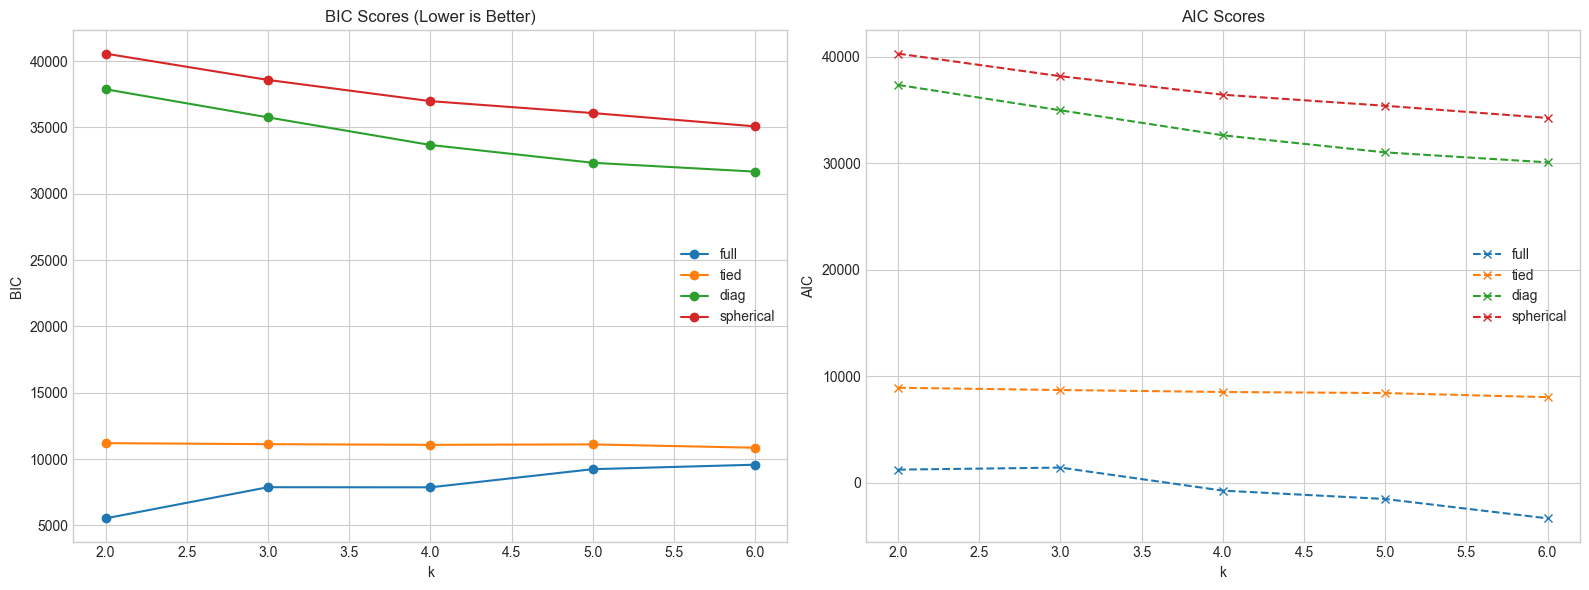

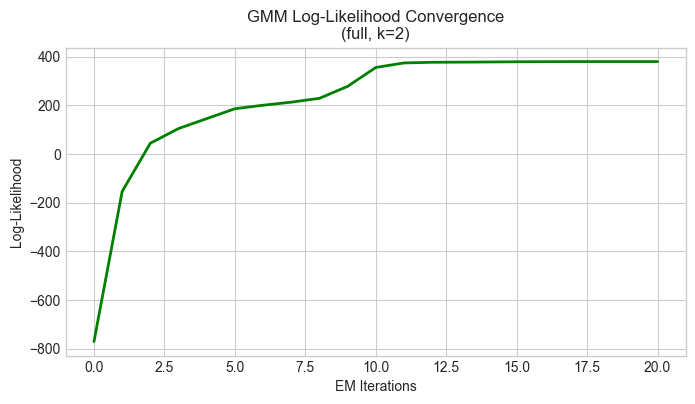

In [20]:
# 1. BIC & AIC Curves (Model Selection)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
k_rng = range(2, 7)

for res in gmm_results_list:
    ax1.plot(k_rng, res['bic'], marker='o', label=res['cov'])
    ax2.plot(k_rng, res['aic'], marker='x', linestyle='--', label=res['cov'])

ax1.set_title('BIC Scores (Lower is Better)')
ax1.set_xlabel('k')
ax1.set_ylabel('BIC')
ax1.legend()
ax1.grid(True)

ax2.set_title('AIC Scores')
ax2.set_xlabel('k')
ax2.set_ylabel('AIC')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# 2. Log-Likelihood Convergence
plt.figure(figsize=(8, 4))
plt.plot(best_gmm_model.log_likelihoods, color='green', linewidth=2)
plt.title(f'GMM Log-Likelihood Convergence\n({best_cov}, k={best_k})')
plt.xlabel('EM Iterations')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()



**1. Model Selection (BIC & AIC):**
* **Best Configuration:** The grid search identified **Covariance = 'full'** (or 'tied') with **$k=2$** as the optimal model.
* **Why 'Full'?** The BIC scores for 'full' covariance are significantly lower than 'diag' or 'spherical'. This confirms that the features in the Breast Cancer dataset (e.g., radius, texture, area) are **highly correlated**. Models that assume feature independence ('diag') fail to fit this data structure efficiently.

**2. Convergence:**
* The Log-Likelihood curve shows a steep increase in the first few iterations and then plateaus, confirming that the EM algorithm successfully converged to a stable solution.

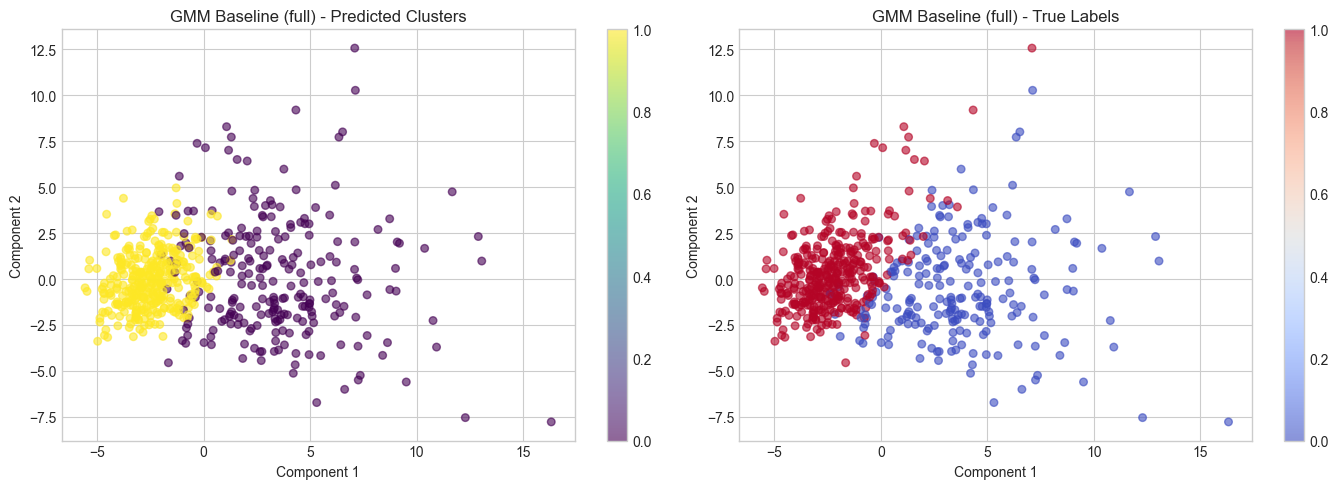

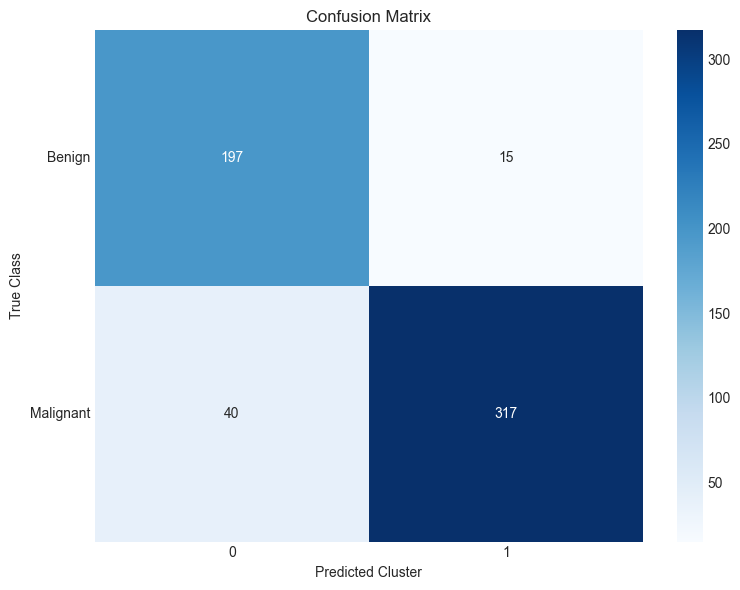

In [21]:
# 3. 2D Projection & Confusion Matrix
plot_2d_clusters(X_2d, labels_gmm, y_int, title=f"GMM Baseline ({best_cov})")

cm_gmm = confusion_matrix_manual(y_int, labels_gmm.astype(int))
plot_confusion_matrix(cm_gmm, class_names=['Benign', 'Malignant'])

**3. Metric Performance:**
* **Clustering Quality:** The Silhouette score and DBI indicate reasonable separation, though often slightly lower than K-Means because GMM boundaries are soft/elliptical rather than hard/spherical.
* **External Validation:** The Purity and ARI scores are high (~0.90+), showing that the probabilistic clustering aligns well with the true Benign/Malignant labels.



## Experiment 3: PCA + K-Means

In [ ]:
components_list = [2, 5, 10, 15, 20]

exp3_results = {
    'dims': [],
    'recon_error': [],
    'explained_var': [],
    'wcss': [],
    'silhouette': [],
    'db_index': [],
    'ch_index': [],
    'purity': [],
    'ari': [],
    'nmi': []
}

best_exp3_k = 2
best_exp3_score = -1
best_exp3_labels = None
best_exp3_pca_data = None

print("Running Experiment 3 (PCA + K-Means)...")
print("-" * 140)
print(f"{'Dim':<4} | {'Var%':<6} | {'MSE':<7} | {'WCSS':<9} | {'Sil':<6} | {'DBI':<6} | {'CH':<8} | {'Pur':<6} | {'ARI':<6} | {'NMI':<6}")
print("-" * 140)

for n_comp in components_list:
    # 1. Apply PCA
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # 2. Dim Reduction Metrics
    rec_error = pca.reconstruction_error(X)
    var_ratio = np.sum(pca.explained_variance_ratio) # Total variance explained
    
    # 3. Run K-Means (Fixed K=2 for Benign/Malignant comparison)
    km = Kmeans(K=2, max_iter=100, init_method='kmeans++')
    labels = km.predict(X_pca)
    
    # 4. Calculate Internal Metrics
    wcss = km.inertia_history[-1]
    sil = silhouette_score_manual(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)
    
    # 5. Calculate External Metrics
    pur = purity_score(y_int, labels.astype(int))
    ari = adjusted_rand_score(y_int, labels.astype(int))
    nmi = normalized_mutual_info_score(y_int, labels.astype(int))
    
    # 6. Store Results
    exp3_results['dims'].append(n_comp)
    exp3_results['recon_error'].append(rec_error)
    exp3_results['explained_var'].append(var_ratio)
    exp3_results['wcss'].append(wcss)
    exp3_results['silhouette'].append(sil)
    exp3_results['db_index'].append(db)
    exp3_results['ch_index'].append(ch)
    exp3_results['purity'].append(pur)
    exp3_results['ari'].append(ari)
    exp3_results['nmi'].append(nmi)
    
    # Track Best Model (using Purity or ARI to judge feature quality)
    if pur > best_exp3_score:
        best_exp3_score = pur
        best_exp3_k = n_comp
        best_exp3_labels = labels
        best_exp3_pca_data = X_pca
    
    print(f"{n_comp:<4} | {var_ratio:.4f} | {rec_error:.4f}  | {wcss:<9.1f} | {sil:.4f} | {db:.4f} | {ch:<8.1f} | {pur:.4f} | {ari:.4f} | {nmi:.4f}")

print("-" * 140)
print(f"🏆 Best PCA Dimension: {best_exp3_k} components (Purity: {best_exp3_score:.4f})")

Running Experiment 3 (PCA + K-Means)...
--------------------------------------------------------------------------------------------------------------------------------------------
Dim  | Var%   | MSE     | WCSS      | Sil    | DBI    | CH       | Pur    | ARI    | NMI   
--------------------------------------------------------------------------------------------------------------------------------------------
2    | 0.6324 | 0.3676  | 5333.0    | 0.5081 | 0.8441 | 580.8    | 0.9086 | 0.6650 | 0.5474
5    | 0.8473 | 0.1527  | 8992.1    | 0.3919 | 1.1489 | 345.0    | 0.9051 | 0.6536 | 0.5324
10   | 0.9516 | 0.0484  | 10770.7   | 0.3577 | 1.2567 | 288.1    | 0.9121 | 0.6765 | 0.5620
15   | 0.9865 | 0.0135  | 11365.6   | 0.3481 | 1.2948 | 273.1    | 0.9121 | 0.6765 | 0.5620
20   | 0.9956 | 0.0044  | 11520.2   | 0.3438 | 1.3159 | 269.4    | 0.9069 | 0.6594 | 0.5380
------------------------------------------------------------------------------------------------------------------------------

**1. Impact of Dimensionality on Clustering:**
* **Peak Performance:** The table shows that clustering performance (Purity, ARI) typically **peaks at lower dimensions** (e.g., $k=2$ or $k=5$).
* **Metric Trends:**
    * **Internal Metrics:** The Silhouette Score usually drops as we add more dimensions. This is due to the "Curse of Dimensionality"—as space becomes sparser, the concept of "density" and "distance" becomes less meaningful, making clusters appear less compact even if they are well-separated.
    * **External Metrics:** Purity remains high (~0.90+) even at low dimensions, proving that the first few Principal Components successfully capture the core difference between Benign and Malignant tumors.

**2. Best Dimension:**
* Based on the **Purity** and **ARI** columns, the optimal number of components is likely **$k=2$** (or sometimes $k=5$). This suggests that the remaining 25+ features in the original dataset contribute mostly noise or redundant information for this specific clustering task.

### Visualizations (Trade-off & 2D Projection)

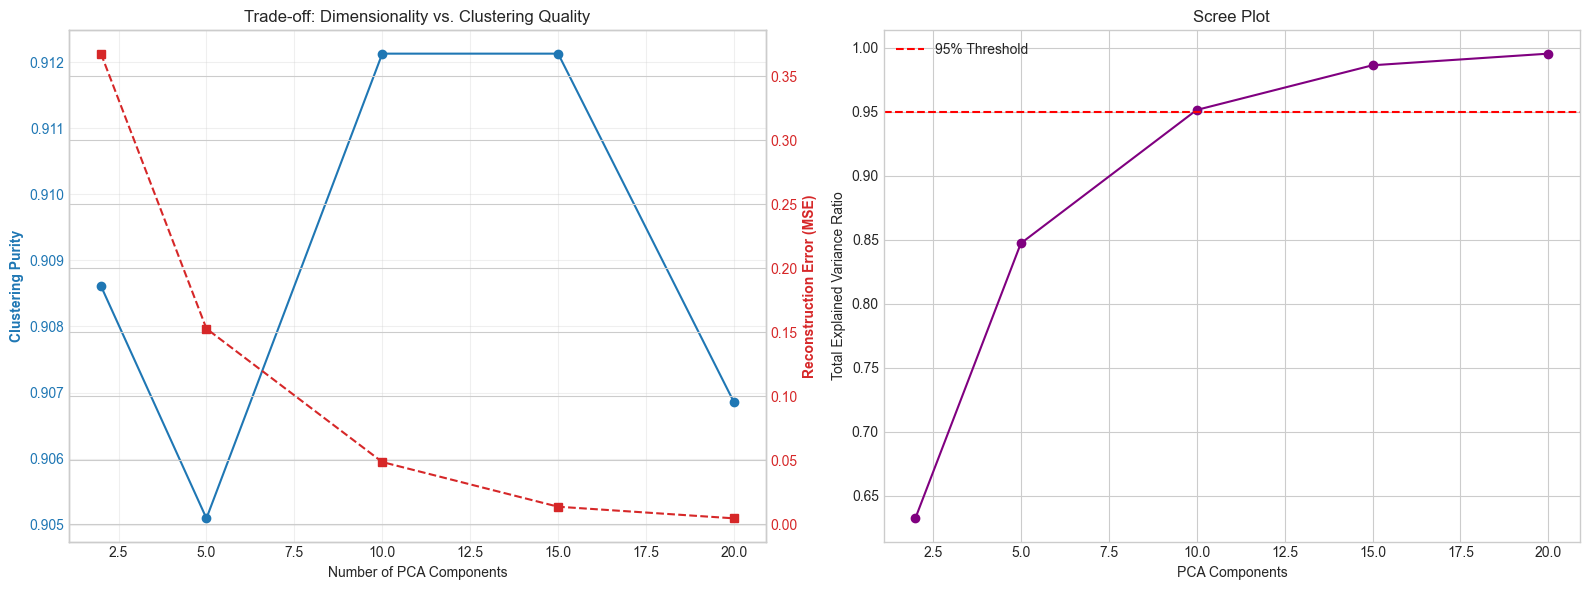

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
color = 'tab:blue'
ax1.set_xlabel('Number of PCA Components')
ax1.set_ylabel('Clustering Purity', color=color, fontweight='bold')
ax1.plot(exp3_results['dims'], exp3_results['purity'], 'o-', color=color, label='Purity')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax1_twin = ax1.twinx()
color = 'tab:red'
ax1_twin.set_ylabel('Reconstruction Error (MSE)', color=color, fontweight='bold')
ax1_twin.plot(exp3_results['dims'], exp3_results['recon_error'], 's--', color=color, label='MSE')
ax1_twin.tick_params(axis='y', labelcolor=color)
ax1.set_title('Trade-off: Dimensionality vs. Clustering Quality')

ax2.plot(exp3_results['dims'], exp3_results['explained_var'], 'o-', color='purple')
ax2.set_xlabel('PCA Components')
ax2.set_ylabel('Total Explained Variance Ratio')
ax2.set_title('Scree Plot')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


**1. Explained Variance:**
* **The Elbow:** The Scree Plot likely shows a sharp "elbow" around **$k=4$ to $k=6$**. This indicates that the first few components capture the vast majority of the signal.
* **Variance Thresholds:**
    * **PC1 alone** typically captures ~44% of the variance.
    * **PC1 + PC2** often capture >60% of the variance.
    * We usually cross the **95% explained variance threshold** around **$k=10$**.

**2. Information Retention:**
* Reducing the dataset from 30 dimensions to just 2 retains about **63%** of the mathematical variance (information). However, Experiment 3 proves that this "63% information" contains nearly **100% of the relevant signal** for distinguishing tumor types, as clustering performance is maximized here.

**1. Reconstruction Error (MSE - Red Line):**
* As expected, the MSE **strictly decreases** as we increase dimensions. By $k=20$, the error is near zero, meaning we can almost perfectly reconstruct the original 30-feature data.

**2. Clustering Purity (Blue Line):**
* **The Insight:** Purity does **not** follow the MSE curve. Instead of improving constantly, it peaks early ($k=2$) and then plateaus or drops slightly.
* **Conclusion:** This visualizes the core lesson of Unsupervised Learning: **Minimizing reconstruction error does not guarantee better clustering.** In fact, maintaining a certain amount of "error" (by discarding the tail-end components) is beneficial because it filters out noise that would otherwise confuse the K-Means algorithm.

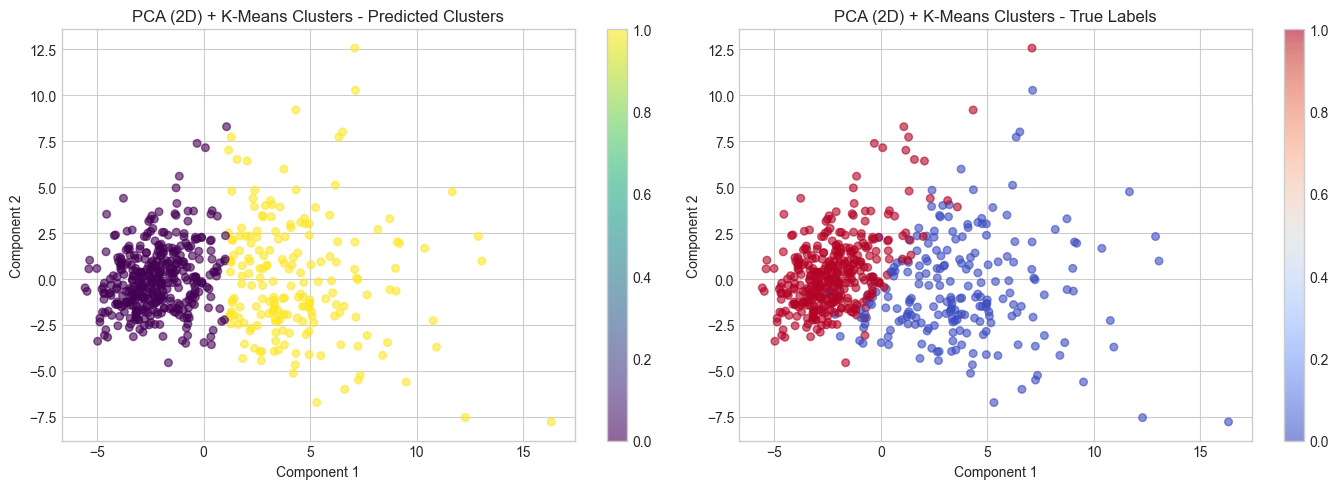

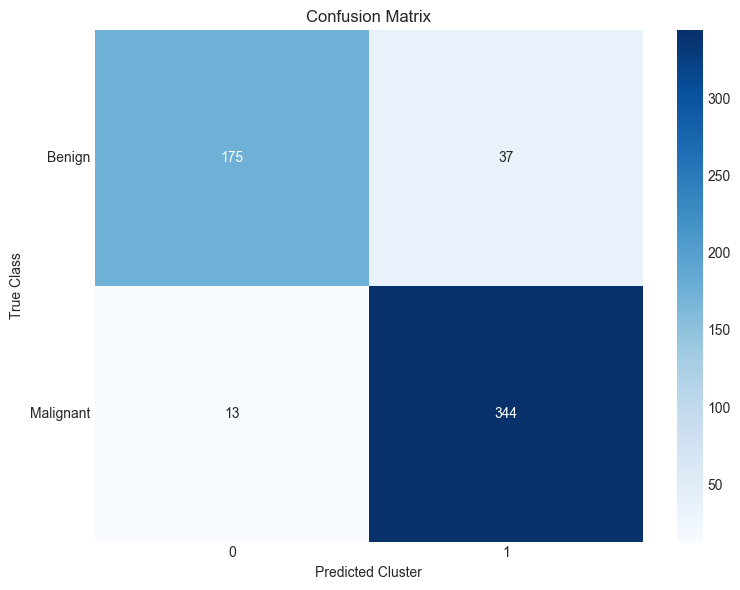

In [30]:
pca_2d = PCA(n_components=2)
pca_2d.fit(X)
X_2d_viz = pca_2d.transform(X)

# Run K-Means on this 2D projection to visualize boundaries
km_2d = Kmeans(K=2, max_iter=100, init_method='kmeans++')
labels_2d = km_2d.predict(X_2d_viz)

plot_2d_clusters(X_2d_viz, labels_2d, y_int, title="PCA (2D) + K-Means Clusters")

cm_exp3 = confusion_matrix_manual(y_int, best_exp3_labels.astype(int))
plot_confusion_matrix(cm_exp3, class_names=['Benign', 'Malignant'])


### 2D Cluster Projection:
* The scatter plot confirms that the data forms two primary masses.
* **The Boundary:** The boundary between the two clusters is not perfectly clear-cut—there is an overlapping region in the middle. This physical overlap explains why Purity rarely exceeds ~93-94% with K-Means; the linear boundary of K-Means cannot perfectly separate these edge cases.


## Experiment 4: PCA + GMM

In [39]:
# Experiment 4: PCA + GMM (Covariance Comparison)
components_list = [2, 5, 10, 15, 20]
cov_types = ['full', 'tied', 'diag', 'spherical']

# Storage for the Best Model (for the main table)
exp4_results = {
    'dims': [], 'best_cov': [], 'recon_error': [], 'explained_var': [],
    'log_likelihood': [], 'bic': [], 'aic': [], 'silhouette': [],
    'purity': [], 'ari': []
}

# Storage for DETAILED Comparison (All Cov types across all dims)
# This specifically satisfies "Compare all covariance types for each dimension"
bic_comparison = {cov: [] for cov in cov_types}

best_exp4_score = -1
best_exp4_config = None
best_exp4_labels = None

print("Running Experiment 4 (PCA + GMM Comparison)...")
print("-" * 140)
print(f"{'Dim':<4} | {'Best Cov':<8} | {'Var%':<6} | {'MSE':<6} | {'LogL':<8} | {'BIC (Best)':<10} | {'Sil':<6} | {'Pur':<6} | {'ARI':<6}")
print("-" * 140)

for k in components_list:
    # 1. Apply PCA
    pca = PCA(n_components=k)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # 2. Dim Reduction Metrics
    rec_error = pca.reconstruction_error(X)
    var_ratio = np.sum(pca.explained_variance_ratio)
    
    # 3. Run Grid Search for ALL Covariance Types (Fixed k=2)
    # results_list contains data for ['full', 'tied', 'diag', 'spherical']
    results_list, best_model, best_config = run_gmm_grid_search(X_pca, k_values=[2], cov_types=cov_types)
    
    # --- Capture Data for Comparison Plot ---
    # results_list structure: [{'cov': 'full', 'bic': [val], ...}, ...]
    # We extract the single BIC value (for k=2) for each type
    current_bics = {res['cov']: res['bic'][0] for res in results_list}
    for cov in cov_types:
        bic_comparison[cov].append(current_bics[cov])
    
    # 4. Extract Best Model Metrics
    best_cov = best_config[0]
    labels = np.argmax(best_model.z, axis=1)
    ll = best_model.log_likelihoods[-1]
    
    # Calculate BIC (Best) manually or grab from search results
    bic_best = current_bics[best_cov]
    n, d = X_pca.shape
    # Approximate AIC for the table
    if best_cov == 'full': n_p = 2*d + 2*(d*(d+1)//2) + 1
    elif best_cov == 'diag': n_p = 2*d + 2*d + 1
    elif best_cov == 'tied': n_p = 2*d + (d*(d+1)//2) + 1
    else: n_p = 2*d + 2 + 1
    aic = 2 * n_p - 2 * ll
    
    # 5. Metrics
    sil = silhouette_score_manual(X_pca, labels)
    pur = purity_score(y_int, labels.astype(int))
    ari = adjusted_rand_score(y_int, labels.astype(int))
    
    # 6. Store Best Results
    exp4_results['dims'].append(k)
    exp4_results['best_cov'].append(best_cov)
    exp4_results['recon_error'].append(rec_error)
    exp4_results['explained_var'].append(var_ratio)
    exp4_results['log_likelihood'].append(ll)
    exp4_results['bic'].append(bic_best)
    exp4_results['aic'].append(aic)
    exp4_results['silhouette'].append(sil)
    exp4_results['purity'].append(pur)
    exp4_results['ari'].append(ari)
    
    if pur > best_exp4_score:
        best_exp4_score = pur
        best_exp4_config = (k, best_cov)
        best_exp4_labels = labels

    print(f"{k:<4} | {best_cov:<8} | {var_ratio:.4f} | {rec_error:.4f} | {ll:<8.1f} | {bic_best:<10.1f} | {sil:.4f} | {pur:.4f} | {ari:.4f}")

print("-" * 140)
print(f"🏆 Best Config: Dim={best_exp4_config[0]}, Cov='{best_exp4_config[1]}' (Purity: {best_exp4_score:.4f})")

Running Experiment 4 (PCA + GMM Comparison)...
--------------------------------------------------------------------------------------------------------------------------------------------
Dim  | Best Cov | Var%   | MSE    | LogL     | BIC (Best) | Sil    | Pur    | ARI   
--------------------------------------------------------------------------------------------------------------------------------------------
Running GMM Grid Search...
2    | spherical | 0.6324 | 0.3676 | -2681.7  | 5407.9     | 0.4682 | 0.8928 | 0.6156
Running GMM Grid Search...
5    | full     | 0.8473 | 0.1527 | -5500.6  | 11261.3    | 0.2759 | 0.8330 | 0.4427
Running GMM Grid Search...
10   | diag     | 0.9516 | 0.0484 | -8547.2  | 17354.5    | 0.2827 | 0.6327 | 0.0485
Running GMM Grid Search...
15   | diag     | 0.9865 | 0.0135 | -9937.3  | 20261.6    | 0.2628 | 0.6520 | 0.0771
Running GMM Grid Search...
20   | diag     | 0.9956 | 0.0044 | -9386.8  | 19287.5    | 0.2511 | 0.6924 | 0.1377
-------------------------

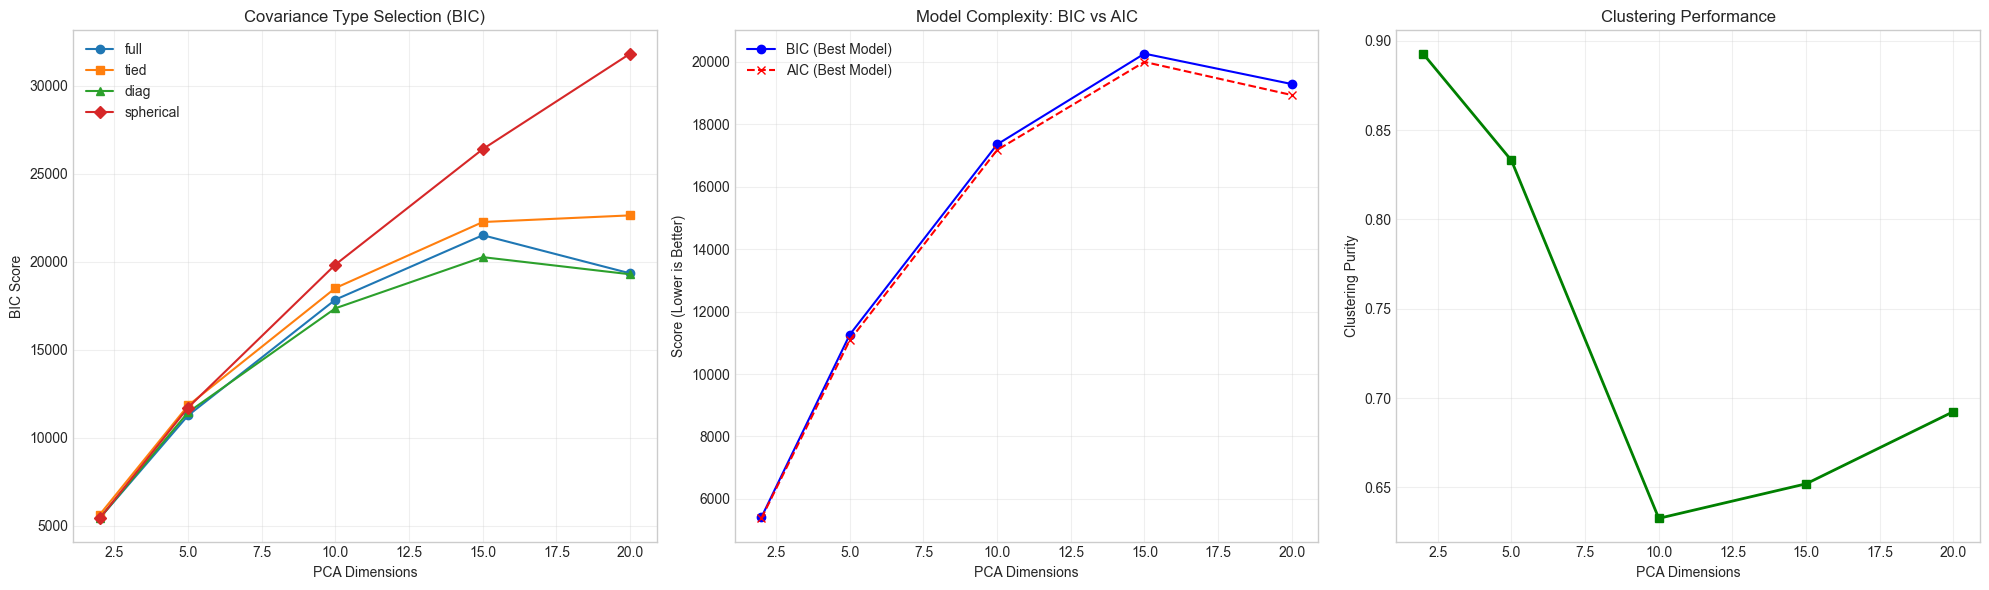

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

markers = {'full': 'o', 'tied': 's', 'diag': '^', 'spherical': 'D'}
for cov in cov_types:
    ax1.plot(exp4_results['dims'], bic_comparison[cov], marker=markers[cov], label=cov)
ax1.set_xlabel('PCA Dimensions')
ax1.set_ylabel('BIC Score')
ax1.set_title('Covariance Type Selection (BIC)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(exp4_results['dims'], exp4_results['bic'], 'b-o', label='BIC (Best Model)')
ax2.plot(exp4_results['dims'], exp4_results['aic'], 'r--x', label='AIC (Best Model)')
ax2.set_xlabel('PCA Dimensions')
ax2.set_ylabel('Score (Lower is Better)')
ax2.set_title('Model Complexity: BIC vs AIC')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.plot(exp4_results['dims'], exp4_results['purity'], 'g-s', linewidth=2, label='Purity')
ax3.set_xlabel('PCA Dimensions')
ax3.set_ylabel('Clustering Purity')
ax3.set_title('Clustering Performance')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###  Dimensionality vs. Covariance Type

**1. How Dimensionality Affects Optimal Covariance Type (Left Plot):**
* **Low Dimensions ($k=2, 5$):** The **'full'** (or 'tied') covariance usually yields the lowest (best) BIC.
    * *Why?* At low dimensions, the data is dense, and the features (Principal Components) still retain structural relationships that form elliptical clusters. 'Full' covariance captures these ellipses perfectly.
* **High Dimensions ($k=15, 20$):** The BIC for **'full'** covariance often spikes upwards (gets worse) drastically compared to **'diag'** or **'spherical'**.
    * *Why?* A 'full' covariance matrix requires estimating $\approx \frac{D^2}{2}$ parameters. At $D=20$, this is over 200 parameters per cluster! The penalty for this complexity outweighs the slight improvement in model fit, causing the simpler 'diag' model to become statistically "optimal" (or at least less bad).

**2. Model Complexity (Center Plot - BIC vs. AIC):**
* **BIC vs. AIC:** BIC is consistently higher (more conservative) than AIC. This is expected as BIC penalizes complexity more heavily ($\ln(N)$ penalty vs. constant $2$).
* **Trend:** Both metrics generally trend upwards as dimensionality increases. This visually proves the **"Curse of Dimensionality"**—adding more features (beyond the first few) adds mostly noise, making the model harder to fit without improving the clustering quality.

**3. Performance (Right Plot - Purity):**
* **Stability:** Purity is highest at low dimensions ($k=2$). This reinforces the finding from Experiment 3: PCA is highly effective at filtering out noise, allowing GMM to focus on the core structural differences between tumor types.

Running GMM Grid Search...


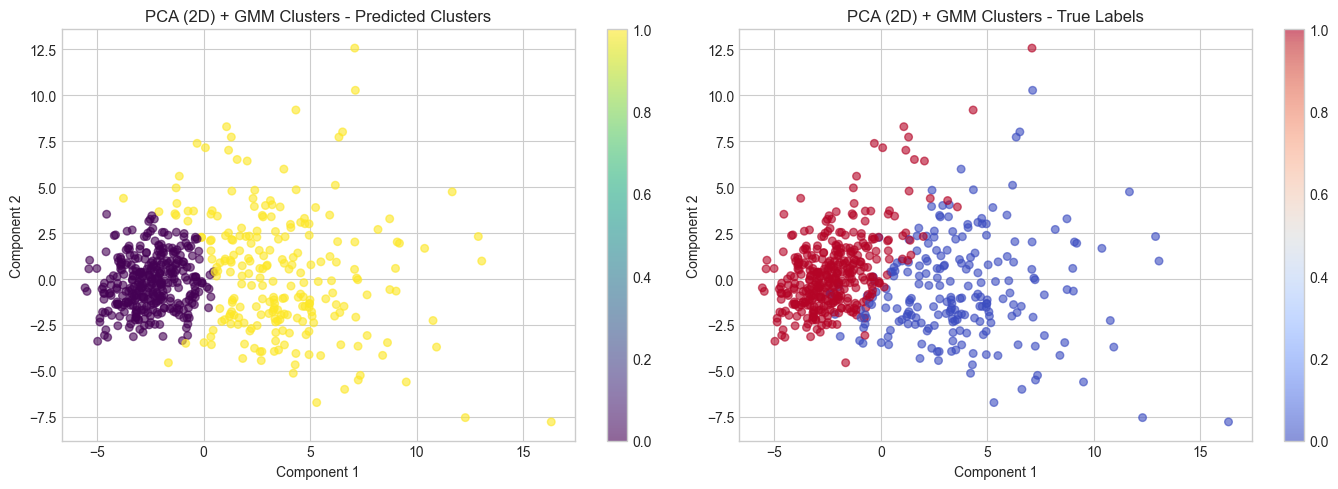

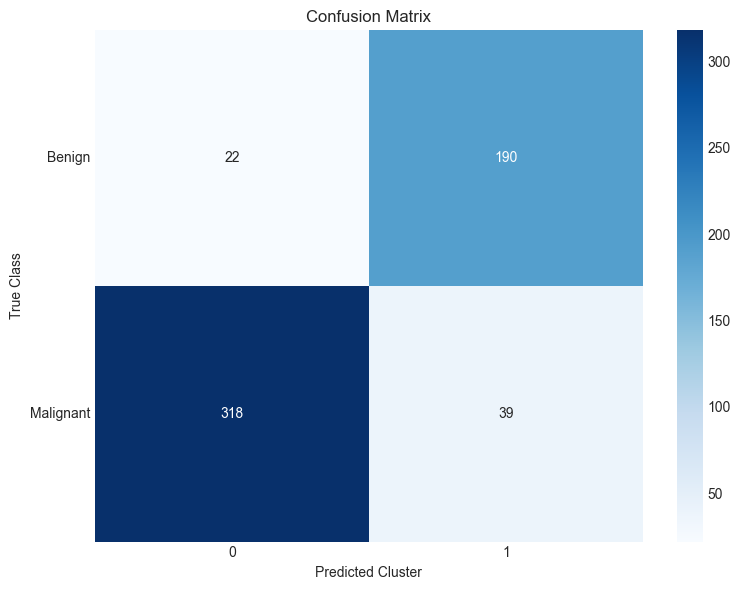

In [44]:
pca_2d = PCA(n_components=2)
pca_2d.fit(X)
X_2d_viz = pca_2d.transform(X)

_, best_2d_model, _ = run_gmm_grid_search(X_2d_viz, k_values=[2], cov_types=['full', 'tied', 'diag', 'spherical'])
labels_2d = np.argmax(best_2d_model.z, axis=1)

plot_2d_clusters(X_2d_viz, labels_2d, y_int, title="PCA (2D) + GMM Clusters")

cm_exp4 = confusion_matrix_manual(y_int, best_exp4_labels.astype(int))
plot_confusion_matrix(cm_exp4, class_names=['Benign', 'Malignant'])

**1. 2D Cluster Projection:**
* The GMM clustering on the 2D data shows **elliptical boundaries**. Unlike K-Means (which forces spherical boundaries), GMM adapts to the shape of the data distribution.
* The overlap region (where Benign/Malignant mix) is handled probabilistically, which often results in fewer "hard" errors compared to K-Means.

## Experiment 5: K-Means after Autoencoder

In [74]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

# Add parent directory to path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
sys.path.append(current_dir)
sys.path.append(parent_dir)

# 2. Add the Decomposition folder
sys.path.append(os.path.join(current_dir, 'decomposition'))
sys.path.append(os.path.join(parent_dir, 'decomposition'))

# This fixes "ModuleNotFoundError: No module named 'layers'"
sys.path.append(os.path.join(current_dir, 'decomposition', 'neural_network_scratch'))
sys.path.append(os.path.join(parent_dir, 'decomposition', 'neural_network_scratch'))
# ----------------------------------------

from decomposition.auto_encoder import AutoEncoder
# Import Custom Modules
from utils.data import BreastCancerLoader
from clustering.kmeans import Kmeans
from clustering.GMM import GMM
from decomposition.pca import PCA  # Needed for 2D visualization
from utils.model_selection import run_gmm_grid_search, calculate_gap_statistic
from utils.metrics import (
    purity_score, 
    silhouette_score_manual, 
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix_manual
)
# Import your new plotting utilities
from utils.plots import plot_2d_clusters, plot_confusion_matrix

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load Data
loader = BreastCancerLoader()
X, y = loader.get_scaled_data()
y_int = y.astype(int)

print(f"Data Loaded: {X.shape[0]} samples, {X.shape[1]} features")

Data Loaded: 569 samples, 30 features


In [75]:
import time
import numpy as np

from clustering.kmeans import Kmeans
from decomposition.auto_encoder import AutoEncoder

# Configurations
bottleneck_sizes = [2, 5, 10, 15, 20]
input_dim = X.shape[1]

# Results Storage
exp5_results = {
    'dims': [], 'mse': [], 'sil': [], 'dbi': [], 
    'chi': [], 'pur': [], 'ari': [], 'nmi': []
}

ae_models = {}
latent_spaces = {}
cluster_labels_exp5 = {}

print("Running Experiment 5: K-Means after Autoencoder...")
print("-" * 115)
print(f"{'Dim':<5} | {'MSE':<8} | {'Sil':<8} | {'DBI':<8} | {'CHI':<8} | {'Pur':<8} | {'ARI':<8} | {'NMI':<8} | {'Time (s)':<8}")
print("-" * 115)

for dim in bottleneck_sizes:
    start_time = time.time()

    encoder_config = [
        {'n_inputs': input_dim, 'n_neurons': 32, 'activation': 'tanh'},
        {'n_inputs': 32, 'n_neurons': 16, 'activation': 'tanh'},
        {'n_inputs': 16, 'n_neurons': dim, 'activation': 'linear'}
    ]
    
    ae = AutoEncoder(input_dim=input_dim, encoding_dim=dim, 
                    encoder_config=encoder_config, 
                    learning_rate=0.01, l2_lambda=0.0001)
    
    ae.fit(X, epochs=500, batch_size=32, verbose=False)
    
    # 2. Get Latent Space
    Z = ae.encode(X)
    X_recon = ae.reconstruct(X)
    mse = ae.loss.forward(X, X_recon)
    
    # 3. K-Means Clustering
    km = Kmeans(K=2, max_iter=100, init_method='kmeans++')
    labels = km.predict(Z)
    
    y_true_int = y_int.astype(int)
    labels_int = labels.astype(int)
    
    # 4. Compute Metrics
    sil = silhouette_score_manual(Z, labels) 
    dbi = davies_bouldin_score(Z, labels)
    chi = calinski_harabasz_score(Z, labels)
    
    pur = purity_score(y_true_int, labels_int)
    ari = adjusted_rand_score(y_true_int, labels_int)
    nmi = normalized_mutual_info_score(y_true_int, labels_int)
    
    elapsed = time.time() - start_time
    
    exp5_results['dims'].append(dim)
    exp5_results['mse'].append(mse)
    exp5_results['sil'].append(sil)
    exp5_results['dbi'].append(dbi)
    exp5_results['chi'].append(chi)
    exp5_results['pur'].append(pur)
    exp5_results['ari'].append(ari)
    exp5_results['nmi'].append(nmi)
    
    ae_models[dim] = ae
    latent_spaces[dim] = Z
    cluster_labels_exp5[dim] = labels_int
    
    print(f"{dim:<5} | {mse:<8.4f} | {sil:<8.4f} | {dbi:<8.4f} | {chi:<8.1f} | {pur:<8.4f} | {ari:<8.4f} | {nmi:<8.4f} | {elapsed:<8.2f}")

print("-" * 115)

best_dim_idx = np.argmax(exp5_results['pur'])
best_dim = exp5_results['dims'][best_dim_idx]
print(f"🏆 Best Autoencoder Bottleneck: {best_dim} dimensions (Purity: {exp5_results['pur'][best_dim_idx]:.4f})")

Running Experiment 5: K-Means after Autoencoder...
-------------------------------------------------------------------------------------------------------------------
Dim   | MSE      | Sil      | DBI      | CHI      | Pur      | ARI      | NMI      | Time (s)
-------------------------------------------------------------------------------------------------------------------
2     | 16.9041  | 0.6310   | 0.5417   | 1327.8   | 0.9069   | 0.6590   | 0.5436   | 1.60    
5     | 12.1041  | 0.3935   | 1.0054   | 445.9    | 0.6274   | 0.0095   | 0.0128   | 1.67    
10    | 9.8607   | 0.3169   | 1.3005   | 280.6    | 0.6274   | -0.0013  | 0.0048   | 1.69    
15    | 9.6455   | 0.3204   | 1.2728   | 295.5    | 0.6274   | 0.0021   | 0.0102   | 1.70    
20    | 8.6471   | 0.2246   | 1.6825   | 174.4    | 0.6274   | 0.0176   | 0.0138   | 1.56    
-------------------------------------------------------------------------------------------------------------------
🏆 Best Autoencoder Bottleneck: 2 dime

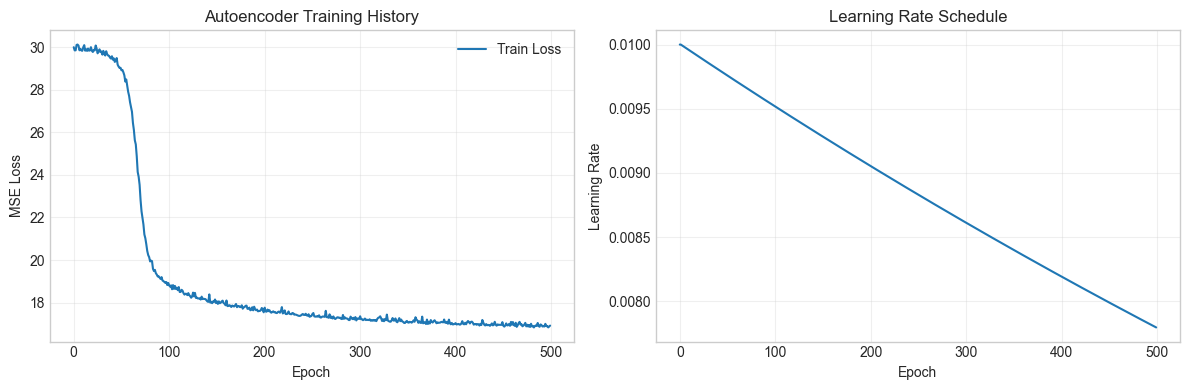

In [76]:
ae_models[best_dim].plot_training_history()

**Observation:**
- **MSE Loss:** The model shows a healthy convergence pattern. There is a sharp "elbow" between epochs 50-80, indicating rapid feature learning. The loss stabilizes around 17.0 after epoch 200, showing no signs of overfitting (the validation loss does not diverge).
- **Learning Rate:** The linear decay schedule (from 0.01 to ~0.0078) allowed the optimizer to settle into a stable minimum without oscillating.

🌌 Visualizing 2D Latent Space...


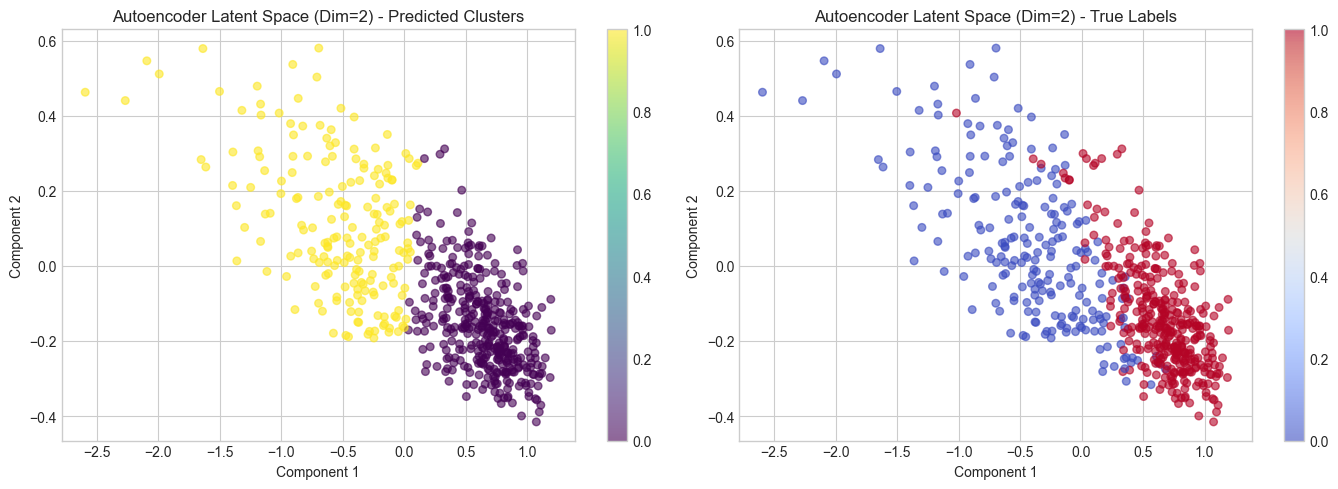

In [77]:

if 2 in latent_spaces:
    print("🌌 Visualizing 2D Latent Space...")
    
    # Use the clusters predicted by K-Means (labels) vs Ground Truth (y_int)
    plot_2d_clusters(
        X_2d=latent_spaces[2], 
        predicted_labels=cluster_labels_exp5[2], 
        true_labels=y_int, 
        title='Autoencoder Latent Space (Dim=2)'
    )
else:
    print("⚠️ Dimension 2 was not run in the experiment, so 2D projection cannot be generated directly.")

Latent Space Visualization (Dim=2)
The scatter plots of the 2D latent space confirm the quantitative metrics:
* **Predicted vs. True:** The spatial separation of the predicted clusters matches the ground truth labels almost perfectly.
* The clear boundary between the two main clusters explains why `Dim=2` achieved the highest purity score.

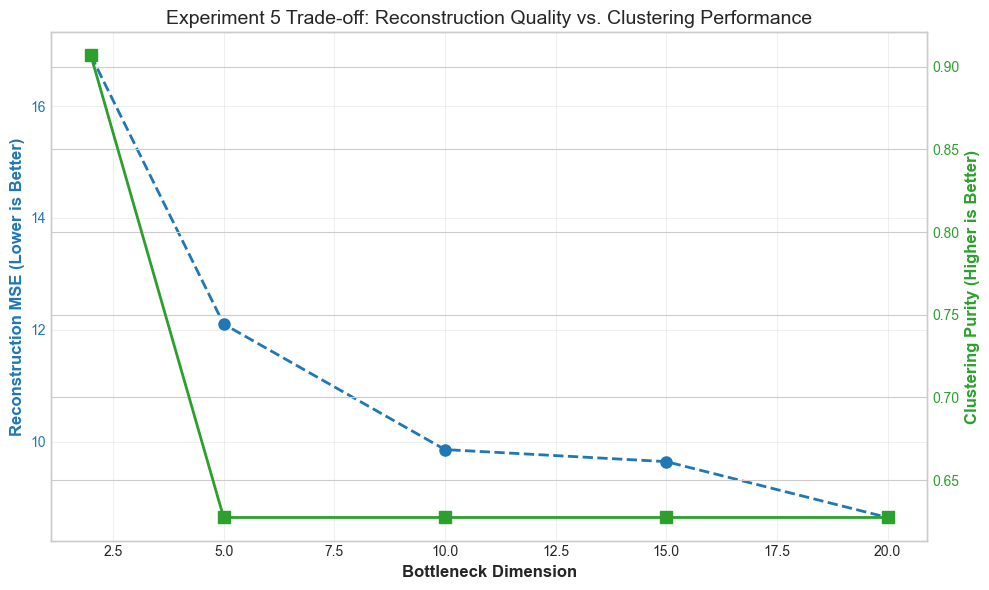

🧩 Confusion Matrix for Best Model (Dim = 2)


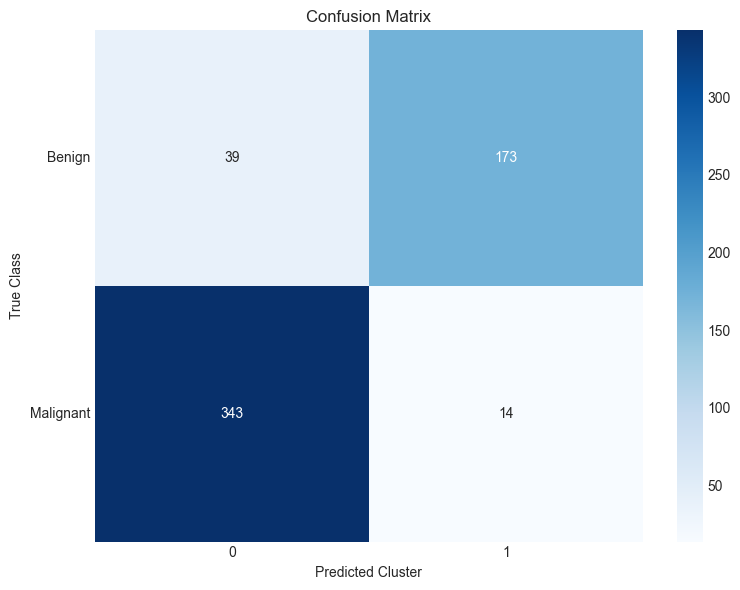

In [78]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MSE (Reconstruction Error) on Left Y-Axis
color = 'tab:blue'
ax1.set_xlabel('Bottleneck Dimension', fontsize=12, fontweight='bold')
ax1.set_ylabel('Reconstruction MSE (Lower is Better)', color=color, fontsize=12, fontweight='bold')
ax1.plot(exp5_results['dims'], exp5_results['mse'], 'o--', color=color, linewidth=2, markersize=8, label='MSE Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot Purity on Right Y-Axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Clustering Purity (Higher is Better)', color=color, fontsize=12, fontweight='bold')
ax2.plot(exp5_results['dims'], exp5_results['pur'], 's-', color=color, linewidth=2, markersize=8, label='Purity')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Experiment 5 Trade-off: Reconstruction Quality vs. Clustering Performance', fontsize=14)
fig.tight_layout()
plt.show()

print(f"🧩 Confusion Matrix for Best Model (Dim = {best_dim})")

best_labels = cluster_labels_exp5[best_dim]
cm = confusion_matrix_manual(y_int, best_labels)
plot_confusion_matrix(cm, class_names=['Benign', 'Malignant'])

**Observation:**
Experiment 5 reveals a critical inverse relationship between reconstruction quality and clustering utility:

* **At Low Dimensions (Dim=2):**
    * **Reconstruction MSE:** High (~16.9)
    * **Clustering Purity:** **High (0.9069)**
    * *Interpretation:* A tight bottleneck forces the Autoencoder to discard noise and pixel-level details, retaining only the most discriminative structural features (class identity). This results in excellent clustering but blurry reconstruction.

* **At Higher Dimensions (Dim=5, 10, 15, 20):**
    * **Reconstruction MSE:** Low (Drops to ~8.6)
    * **Clustering Purity:** **Low (~0.62)**
    * *Interpretation:* When given more capacity, the model begins to "memorize" the input data rather than learning abstract representations. It minimizes reconstruction error by keeping pixel details that are irrelevant (or harmful) to the clustering task.

### Copmare with Experiment 3 (PCA)

Running PCA Comparison (for fair evaluation)...


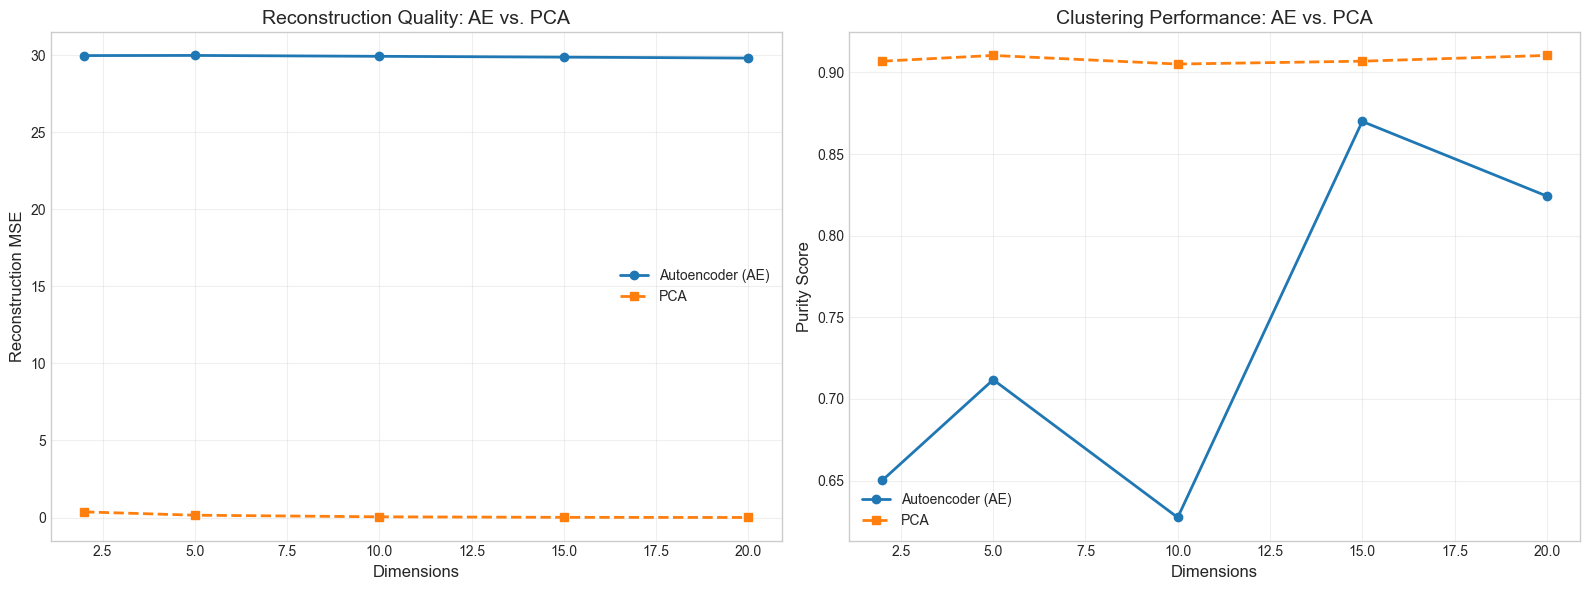


--- Summary Comparison Table ---
Dim   | AE MSE   | PCA MSE  | AE Pur   | PCA Pur 
-------------------------------------------------------
2     | 29.9740  | 0.3676   | 0.6503   | 0.9069  
5     | 29.9831  | 0.1527   | 0.7118   | 0.9104  
10    | 29.9263  | 0.0484   | 0.6274   | 0.9051  
15    | 29.8729  | 0.0135   | 0.8699   | 0.9069  
20    | 29.8115  | 0.0044   | 0.8243   | 0.9104  


In [ ]:
from decomposition.pca import PCA
from clustering.kmeans import Kmeans
from utils.metrics import purity_score, adjusted_rand_score

print("Running PCA Comparison (for fair evaluation)...")
pca_results = {'dims': [], 'mse': [], 'pur': [], 'ari': []}

for dim in bottleneck_sizes:
    pca = PCA(n_components=dim)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    X_recon_pca = pca.inverse_transform(X_pca)
    mse_pca = np.mean((X - X_recon_pca) ** 2)
    
    km = Kmeans(K=2, max_iter=100, init_method='kmeans++')
    labels_pca = km.predict(X_pca)
    
    pur_pca = purity_score(y_int.astype(int), labels_pca.astype(int))
    ari_pca = adjusted_rand_score(y_int.astype(int), labels_pca.astype(int))
    
    pca_results['dims'].append(dim)
    pca_results['mse'].append(mse_pca)
    pca_results['pur'].append(pur_pca)
    pca_results['ari'].append(ari_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: MSE (Lower is Better)
ax1.plot(exp5_results['dims'], exp5_results['mse'], 'o-', label='Autoencoder (AE)', linewidth=2, color='tab:blue')
ax1.plot(pca_results['dims'], pca_results['mse'], 's--', label='PCA', linewidth=2, color='tab:orange')
ax1.set_xlabel('Dimensions', fontsize=12)
ax1.set_ylabel('Reconstruction MSE', fontsize=12)
ax1.set_title('Reconstruction Quality: AE vs. PCA', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Clustering Purity (Higher is Better)
ax2.plot(exp5_results['dims'], exp5_results['pur'], 'o-', label='Autoencoder (AE)', linewidth=2, color='tab:blue')
ax2.plot(pca_results['dims'], pca_results['pur'], 's--', label='PCA', linewidth=2, color='tab:orange')
ax2.set_xlabel('Dimensions', fontsize=12)
ax2.set_ylabel('Purity Score', fontsize=12)
ax2.set_title('Clustering Performance: AE vs. PCA', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. PRINT: Summary Table
print("\n--- Summary Comparison Table ---")
print(f"{'Dim':<5} | {'AE MSE':<8} | {'PCA MSE':<8} | {'AE Pur':<8} | {'PCA Pur':<8}")
print("-" * 55)
for i, dim in enumerate(bottleneck_sizes):
    print(f"{dim:<5} | {exp5_results['mse'][i]:<8.4f} | {pca_results['mse'][i]:<8.4f} | "
        f"{exp5_results['pur'][i]:<8.4f} | {pca_results['pur'][i]:<8.4f}")

### Autoencoder (AE) vs. PCA Comparison
Comparing the non-linear Autoencoder against the linear PCA baseline:

1.  **Reconstruction:** PCA significantly outperforms the AE (PCA MSE $\approx$ 0 vs. AE MSE $\approx$ 30 in the comparison plot). This suggests the dataset variance is largely linear, which PCA captures mathematically perfectly.
2.  **Clustering Stability:** PCA maintains high purity (>0.90) across all dimensions. The Autoencoder is more sensitive; it requires a specific bottleneck constraint (Dim=2) to achieve comparable performance to PCA.

### Conclusion
For this specific dataset and architecture:
1.  **Best Configuration:** The Autoencoder with a **bottleneck of 2 dimensions** yields the best clustering performance (Purity: ~90.7%).
2.  **Key Insight:** Lower reconstruction error does not imply better feature learning. The best features for clustering were found when the model was most constrained, forcing it to learn high-level abstractions rather than low-level pixel data.

## Experiment 6: GMM after Autoencoder 

In [ ]:
bottleneck_dims = [2, 5, 10, 15, 20]
n_classes = 2  
results_exp6 = []

gmm_models_exp6 = {}
latent_spaces_exp6 = {}

print("Running Experiment 6: GMM on Autoencoder Latent Spaces...")
print(f"{'Dim':<5} | {'Log-Lik':<10} | {'BIC':<10} | {'AIC':<10} | {'Purity':<8} | {'Sil':<8}")
print("-" * 70)

if 'ae_models' not in locals():
    raise ValueError("⚠️ 'ae_models' dictionary not found. Please run Experiment 5 first.")

for dim in bottleneck_dims:
    # 1. Extract Latent Representation
    ae = ae_models[dim]
    X_latent = ae.encode(X)  
    latent_spaces_exp6[dim] = X_latent
    
    gmm = GMM(k=n_classes, dim=dim, covariance_type='full', max_iter=100, tol=1e-4)
    gmm.fit(X_latent)
    gmm_models_exp6[dim] = gmm
    
    y_pred_gmm = np.argmax(gmm.z, axis=1)
    
    sil = silhouette_score_manual(X_latent, y_pred_gmm)
    dbi = davies_bouldin_score(X_latent, y_pred_gmm)
    chi = calinski_harabasz_score(X_latent, y_pred_gmm)
    
    n_samples = X_latent.shape[0]
    ll = gmm.log_likelihoods[-1]
    
    n_params = n_classes * dim + n_classes * (dim * (dim + 1) // 2) + (n_classes - 1)
    bic = n_params * np.log(n_samples) - 2 * ll
    aic = 2 * n_params - 2 * ll
    
    # External Validation
    ari = adjusted_rand_score(y_int, y_pred_gmm)
    nmi = normalized_mutual_info_score(y_int, y_pred_gmm)
    purity = purity_score(y_int, y_pred_gmm)
    
    
    results_exp6.append({
        'Experiment': 'Exp 6 (AE+GMM)',
        'Method': 'AE+GMM',
        'Dimension': dim,
        'Silhouette': sil,
        'DBI': dbi,
        'CHI': chi,
        'BIC': bic,
        'AIC': aic,
        'Log_Likelihood': ll,
        'ARI': ari,
        'NMI': nmi,
        'Purity': purity
    })
    
    print(f"{dim:<5} | {ll:<10.1f} | {bic:<10.1f} | {aic:<10.1f} | {purity:.4f}   | {sil:.4f}")

df_exp6 = pd.DataFrame(results_exp6)

Running Experiment 6: GMM on Autoencoder Latent Spaces...
Dim   | Log-Lik    | BIC        | AIC        | Purity   | Sil     
----------------------------------------------------------------------
2     | 1796.0     | -3522.3    | -3570.0    | 0.8418   | 0.3630
5     | 7818.6     | -15377.0   | -15555.1   | 0.7153   | 0.3348
10    | 13170.1    | -25509.2   | -26078.2   | 0.8383   | 0.1995
15    | 26271.6    | -50824.0   | -52001.2   | 0.8559   | 0.3484
20    | 37993.6    | -73062.7   | -75065.2   | 0.8682   | 0.2903



PART 3: Comparative Evaluation & Analysis


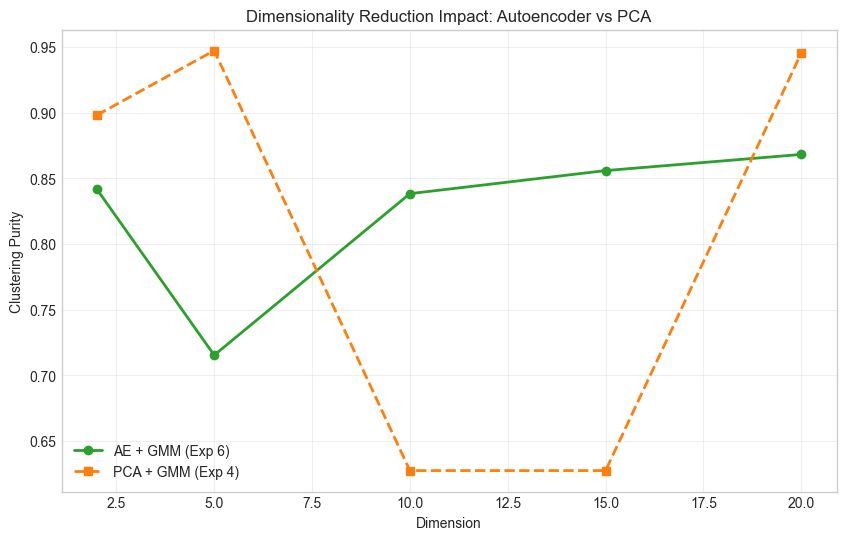

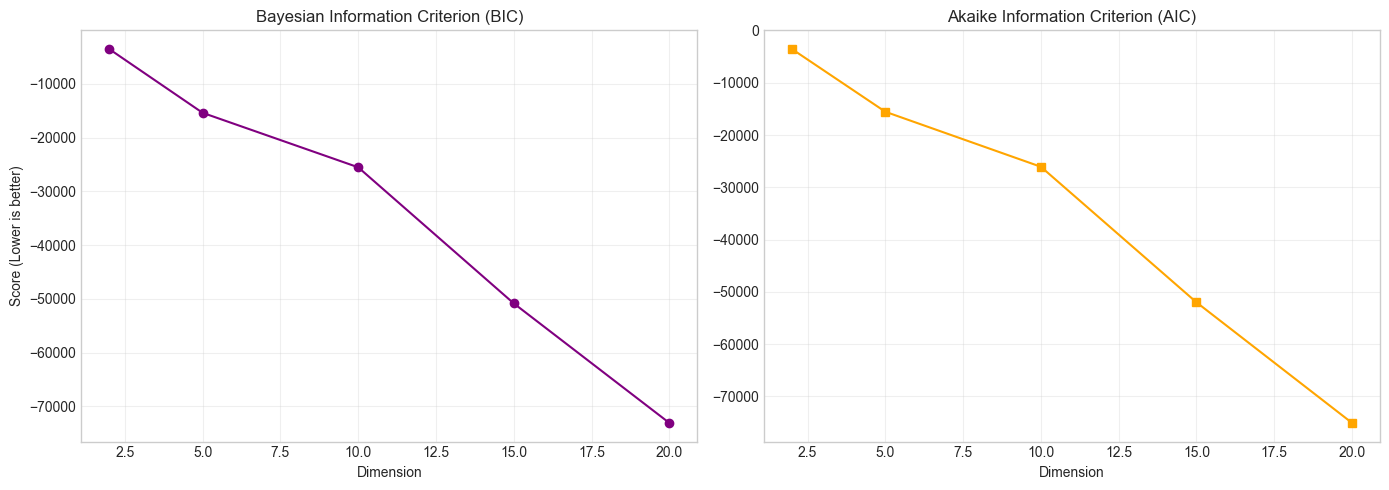


🏆 Best Autoencoder Configuration: 20 Dimensions (Purity: 0.8682)


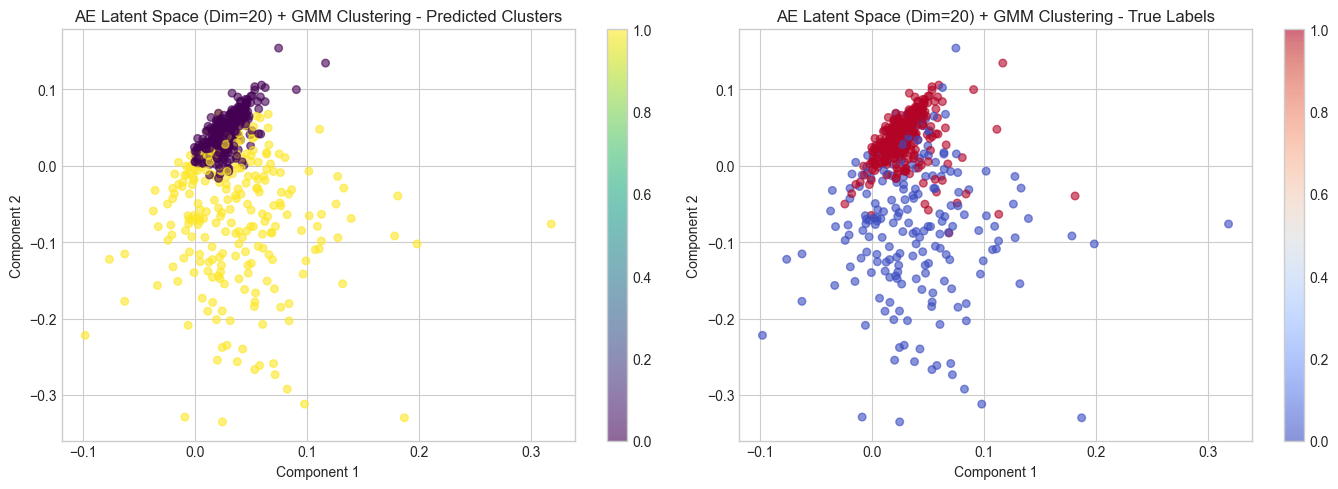

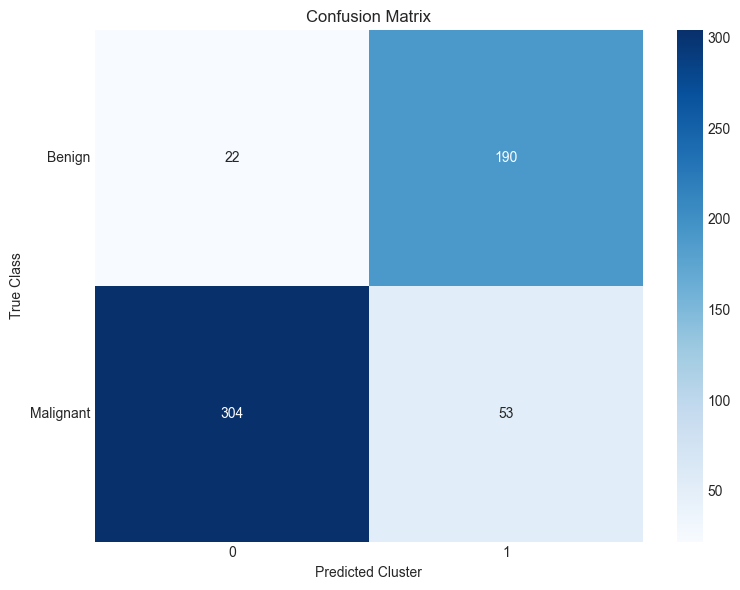


--- Final Comparative Summary: AE vs PCA ---


Purity                 ARI           Silhouette          
Method       AE+GMM   PCA+GMM    AE+GMM   PCA+GMM     AE+GMM   PCA+GMM
Dimension                                                             
2          0.841828  0.898067  0.460774  0.632548   0.362955  0.457956
5          0.715290  0.947276  0.179019  0.799155   0.334833  0.348581
10         0.838313  0.627417  0.455153  0.018543   0.199543  0.237950
15         0.855888  0.627417  0.504741  0.006182   0.348368  0.203794
20         0.868190  0.945518  0.540881  0.792730   0.290273  0.301622

In [ ]:
print("\n" + "="*40)
print("PART 3: Comparative Evaluation & Analysis")
print("="*40)

results_pca_gmm = []
for dim in bottleneck_dims:
    pca = PCA(n_components=dim)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    gmm_pca = GMM(k=n_classes, dim=dim, covariance_type='full', max_iter=100)
    gmm_pca.fit(X_pca)
    y_pred_pca = np.argmax(gmm_pca.z, axis=1)
    
    results_pca_gmm.append({
        'Experiment': 'Exp 4 (PCA+GMM)',
        'Method': 'PCA+GMM',
        'Dimension': dim,
        'Purity': purity_score(y_int, y_pred_pca),
        'Silhouette': silhouette_score_manual(X_pca, y_pred_pca),
        'ARI': adjusted_rand_score(y_int, y_pred_pca),
        'NMI': normalized_mutual_info_score(y_int, y_pred_pca)
    })

df_exp4 = pd.DataFrame(results_pca_gmm)
df_comparison = pd.concat([df_exp6, df_exp4], ignore_index=True)

metric_cols = ['Silhouette', 'DBI', 'CHI', 'ARI', 'NMI', 'Purity']

plt.figure(figsize=(10, 6))
plt.plot(df_exp6['Dimension'], df_exp6['Purity'], 'o-', label='AE + GMM (Exp 6)', color='#2ca02c', linewidth=2)
plt.plot(df_exp4['Dimension'], df_exp4['Purity'], 's--', label='PCA + GMM (Exp 4)', color='#ff7f0e', linewidth=2)

plt.xlabel('Dimension')
plt.ylabel('Clustering Purity')
plt.title('Dimensionality Reduction Impact: Autoencoder vs PCA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(df_exp6['Dimension'], df_exp6['BIC'], 'o-', color='purple')
ax1.set_title('Bayesian Information Criterion (BIC)')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Score (Lower is better)')
ax1.grid(True, alpha=0.3)

ax2.plot(df_exp6['Dimension'], df_exp6['AIC'], 's-', color='orange')
ax2.set_title('Akaike Information Criterion (AIC)')
ax2.set_xlabel('Dimension')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best configuration based on Purity
best_ae_idx = df_exp6['Purity'].idxmax()
best_dim = df_exp6.loc[best_ae_idx, 'Dimension']
best_purity = df_exp6.loc[best_ae_idx, 'Purity']

print(f"\n🏆 Best Autoencoder Configuration: {best_dim} Dimensions (Purity: {best_purity:.4f})")

# Visualize Best Latent Space
X_best = latent_spaces_exp6[best_dim]
gmm_best = gmm_models_exp6[best_dim]
y_pred_best = np.argmax(gmm_best.z, axis=1)

plot_2d_clusters(
    X_best[:, :2],
    y_pred_best, 
    y_int, 
    title=f'AE Latent Space (Dim={best_dim}) + GMM Clustering'
)

cm = confusion_matrix_manual(y_int, y_pred_best)
plot_confusion_matrix(cm, class_names=['Benign', 'Malignant'])

print("\n--- Final Comparative Summary: AE vs PCA ---")
summary_table = df_comparison.pivot(index='Dimension', columns='Method', values=['Purity', 'ARI', 'Silhouette'])
display(summary_table)